# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats, compute_empirical_pvalue, zscore_to_surrogates
from spiketools.plts.space import plot_positions
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.data import restrict_range, get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions
from serial import compute_serial_position_fr, create_df_serial, fit_anova_serial

# Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [7]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [8]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 10

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [9]:
# Set example unit to analyze
uind = 74

In [10]:
# Set which analysis method to run
METHOD = 'ANOVA'  # 'SEGMENT' / 'ANOVA'

# Load Data

In [11]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [12]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data

In [13]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [14]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Get Unit Data

In [15]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [16]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [17]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [18]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Single Trial

In [19]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [20]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [21]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [22]:
# Restrict spikes to the selected trial
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
spike_positions = np.array([t_spike_xs, t_spike_ys])

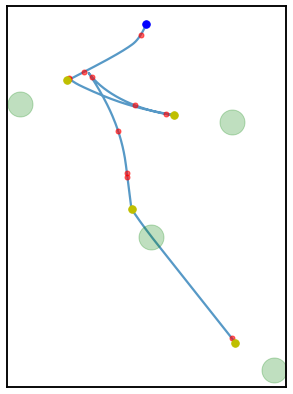

In [23]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
tspikes = {'positions' : np.array([t_spike_xs, t_spike_ys]), 'ms' : 10, 'alpha' : 0.6}
landmarks = [{'positions' : np.array([chest_xs[t_mask], chest_ys[t_mask]]),
              'color' : 'green', 'ms' : 50, 'alpha' : 0.25},
             {'positions' : np.atleast_2d(t_pos[:, 0]).T, 'color' : 'blue', 'ms' : 15},
             {'positions' : np.array(ch_times).T, 'color' : 'y', 'ms' : 15}]
plot_positions(t_pos, tspikes, landmarks, alpha=0.75, figsize=(5, 7))

# Serial Position

### Single Trial

In [24]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [25]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
frs = np.array(list(count.values())) / seg_times

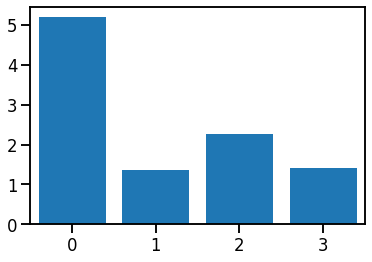

In [26]:
# Plot firing rate per segment (single trial)
plot_bar(frs, count.keys())

### All Trials

In [27]:
# Compute firing rates per segment for all trials
all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, chest_trials, ptimes, positions)

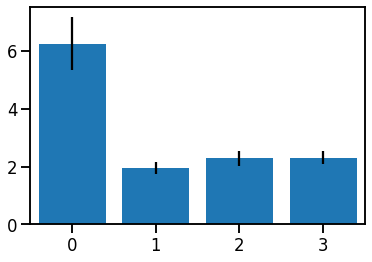

In [28]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))

## Statistical Analyses

In [29]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

## Segment

In [30]:
# compute the firing rate per segement across trials on surrogates
all_surrs = np.zeros(shape=[n_surrogates, 4])
for ind, stimes in enumerate(times_shuffle):
    surrs_frs = compute_serial_position_fr(\
        stimes, nav_starts, chest_openings, chest_trials, ptimes, positions) 
    all_surrs[ind] = np.mean(surrs_frs, 0)

In [31]:
# Compute the empirical p-values and z-scores for each segment
p_vals = [compute_empirical_pvalue(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]
z_scores = [zscore_to_surrogates(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]

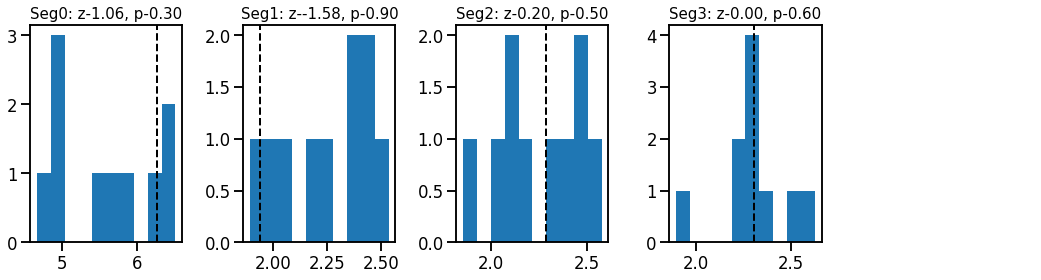

In [32]:
# Plot distribution of surrogates with measured empirical value for each segment (seg1, seg2, seg3, seg4)
for ii, ax in zip(range(4), make_axes(4, wspace=0.4)):
    plot_surrogates(all_surrs[:,ii], all_frs.mean(0)[ii], ax=ax)
    title = 'Seg{}: z-{:1.2f}, p-{:1.2f}'.format(ii, z_scores[ii], p_vals[ii])
    ax.set_title(title, fontdict={'fontsize' : 15}, color=color_pval(p_vals[ii]));

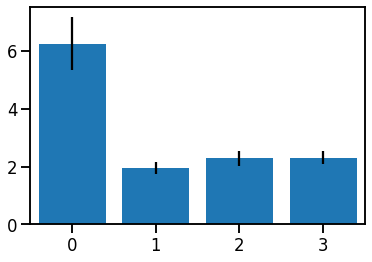

In [33]:
# Plot firing rates per segment across all trials, indicating shuffle significance
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))
ax=plt.gca()
for ind, p_val in enumerate(p_vals):
    if p_val < 0.05:
        ax.text(ind, ax.get_ylim()[1]-0.15*ax.get_ylim()[1],
                '*', c='red', fontdict={'fontsize' : 25}, ha='center')

## ANOVA Analysis

In [34]:
# Create dataframe
df = create_df_serial(all_frs)

In [35]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)
f_val

16.750738855323217

In [36]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    all_frs = compute_serial_position_fr(shuffle, nav_starts, chest_openings, 
                                         chest_trials, ptimes, positions)
    df = create_df_serial(all_frs)
    surrogates[ind] = fit_anova_serial(df)

p-value: 0.00
z-score: 1.82


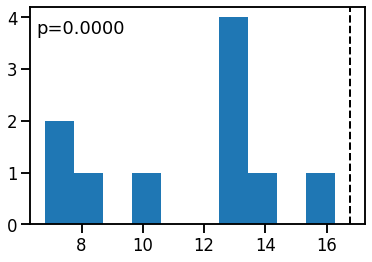

In [37]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

# All Cells

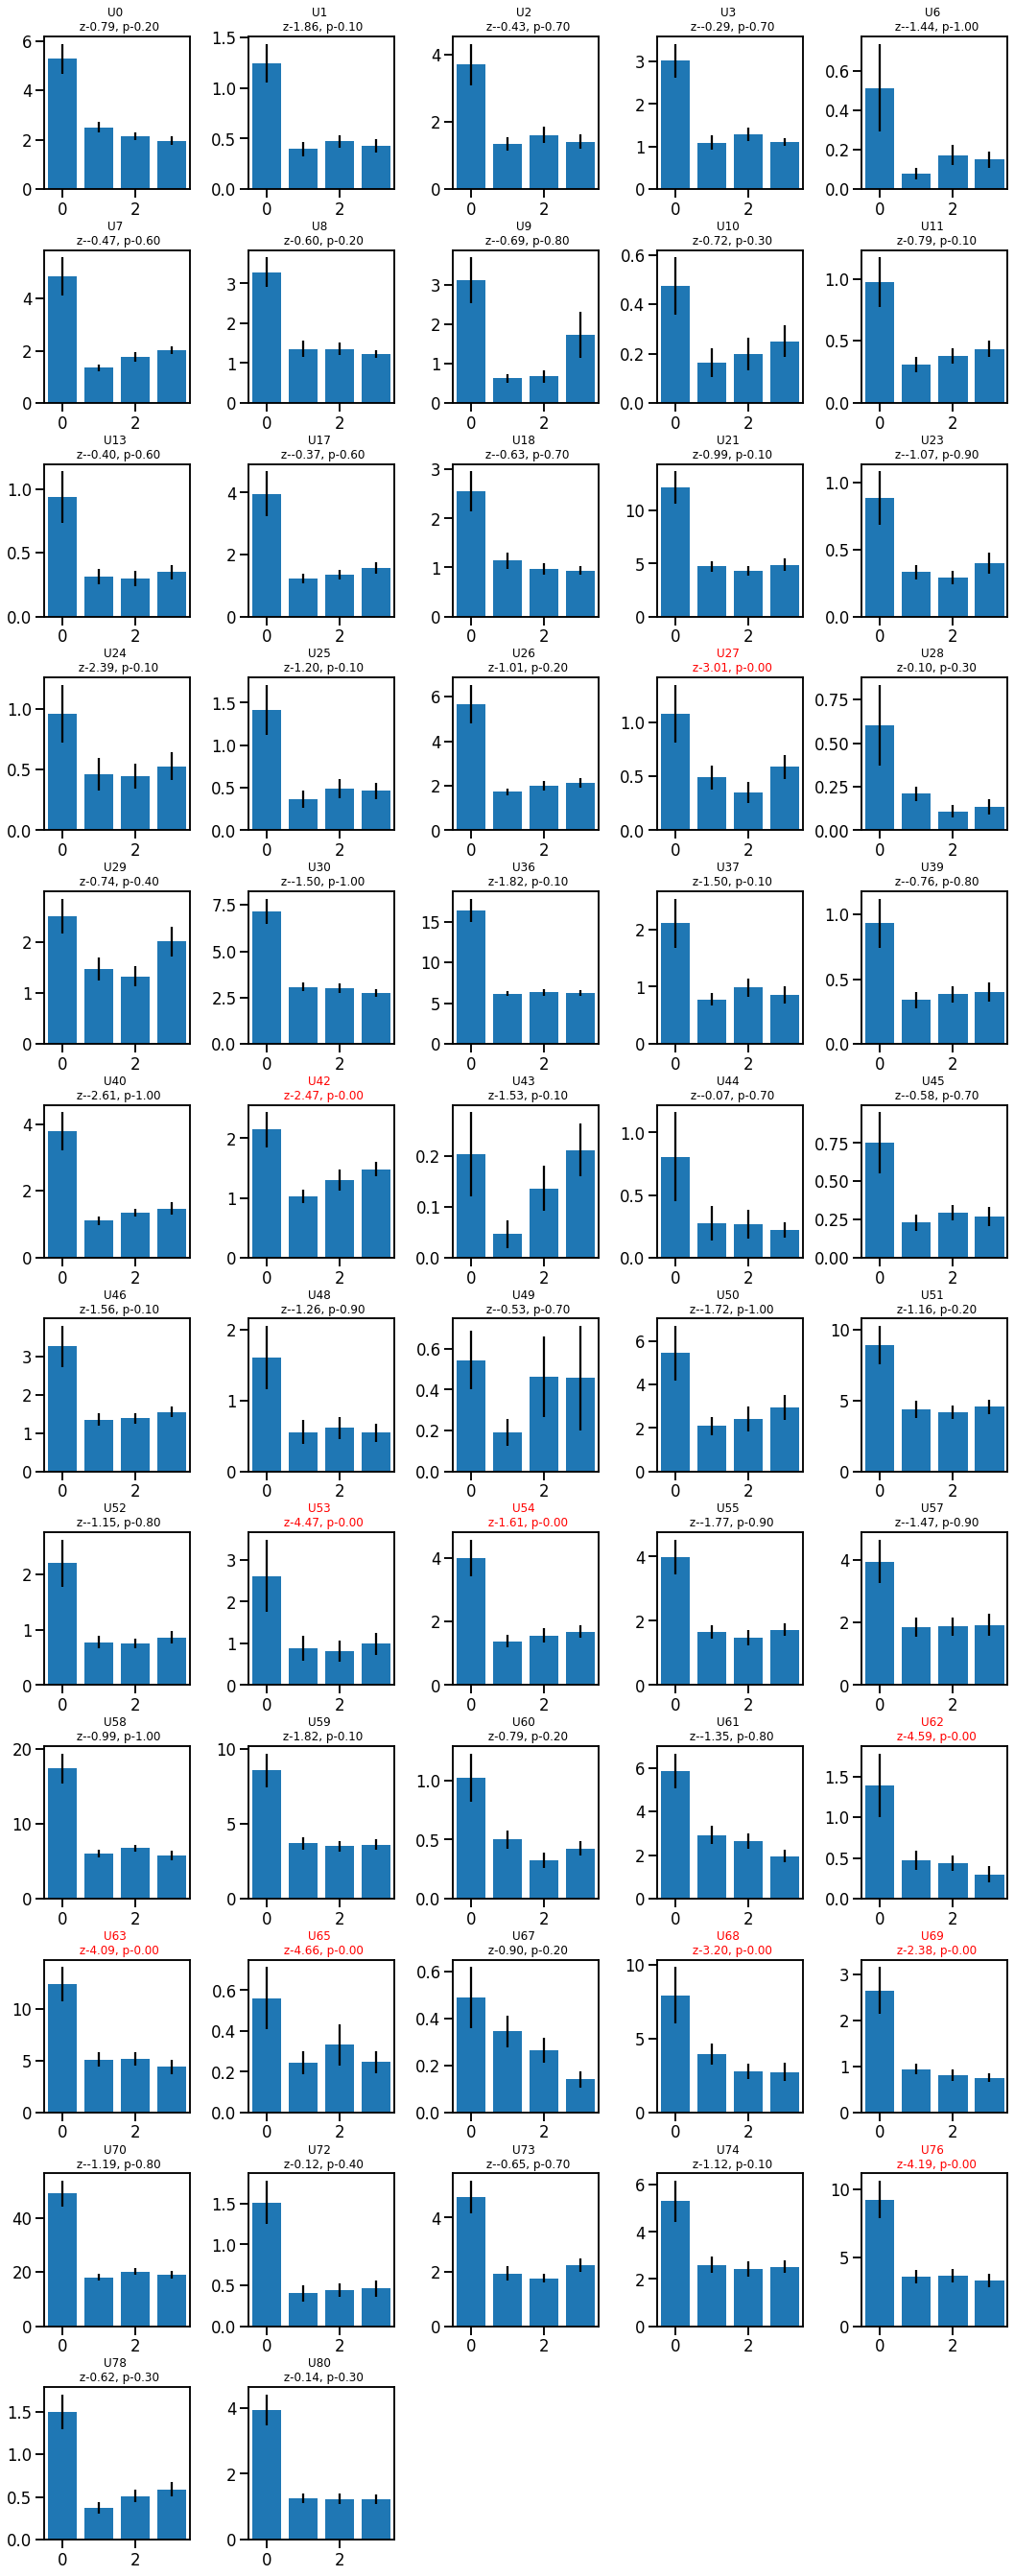

In [38]:
# Plot the firing rate per segment across trials for all units
p_val, z_score = '', ''
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

    spikes = nwbfile.units.get_unit_spike_times(ii)    
    
    all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings,
                                         chest_trials, ptimes, positions)

    if METHOD == 'ANOVA':
        data_value = fit_anova_serial(create_df_serial(all_frs))
    
    # Shuffle analysis
    if METHOD == 'SEGMENT':
        surrogates = np.zeros(shape=[n_surrogates, 4])
    if METHOD == 'ANOVA':
        surrogates = np.zeros(n_surrogates)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
    for ind, shuffle in enumerate(times_shuffle):

        all_frs = compute_serial_position_fr(shuffle, nav_starts, chest_openings, 
                                             chest_trials, ptimes, positions)
        
        if METHOD == 'ANOVA':
            surrogates[ind] = fit_anova_serial(create_df_serial(all_frs))
        if METHOD == 'SEGMENT':
            surrs_frs = compute_serial_position_fr(\
                shuffle, nav_starts, chest_openings, chest_trials, ptimes, positions) 
            surrogates[ind] = np.mean(surrs_frs, 0)

    if METHOD == 'SEGMENT':
        p_vals = [compute_empirical_pvalue(all_frs.mean(0)[ind], surrogates[:, ind]) for ind in range(4)]
        z_scores = [zscore_to_surrogates(all_frs.mean(0)[ind], surrogates[:, ind]) for ind in range(4)]
        title = 'U{}'.format(ii)
        color = 'black'
        
    if METHOD == 'ANOVA':
        p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, verbose=False)
        title = 'U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, p_val)
        color = color_pval(p_val)

    plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0), ax=ax)
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color)
    
    if METHOD == 'SEGMENT':
        for ind, p_val in enumerate(p_vals):
            if p_val < 0.05:
                ax.text(ind, ax.get_ylim()[1]-0.15*ax.get_ylim()[1],
                        '*', c='red', fontdict={'fontsize' : 25}, ha='center')